<a href="https://colab.research.google.com/github/abyaadrafid/Deep-Reinforcement-Learning/blob/master/Policy%20Gradients/Advantage_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advantage Actor Critic
Advantage actor critic variants are perhaps the most well-known algorithms in the actor critic family. Actor critic methods try to incorporate the best from value based and policy based methods. As we have previously known from Q learning variants, there is a connection between the value function and the policy. Actor critic methods modify the policy gradient algorithm to utilize the function.

In the vanilla policy gradient notebook, we have used the discounted returns from actions along with the log probability of the policy to learn our target policy. As it happens, using baselines for expected discounted returns yield better results as the policy updates become smaller; reducing chance of the policy degrading arbitrarily. And the value function serves as a good baseline.

If we consider V(t) as our value function and G our discounted return, instead of using G directly in policy gradient, we can use this : 
```
G - V(s)
A(s) = Q(s,a) - V(s)
```
Also, G is just the Q value in this context. Replacing G with Q(s,a), we get the advantage function A(t), which describes how good or bad an action is. It tells about the extra reward that could be obtained by the agent by taking that particular action. As we are using the advantage function, it is called advantage actor critic. There are variants that use state value or q value directly. 

## Models
There are two models in actor critic methods, which optionally share parameters:

1. The critic : Updates value function parameters. The value function can be action value or state value depending on the implementation specification. In this case we are going to use the state value function.
2. The actor : Updates policy parameters as suggested by the critic.

## A2C over A3C
Asynchronous Actor Critic is one of the most influential Actor Critic methods. A3C provided distributed training over multiple cpu. However, researchers found that the Synchronous version of the algorithm is better suited for GPU training.

The noise introduced by the Asynchronity was initially thought help with regularilization. But the Synchronous variant is more effective with GPUs. That is why we will be implementing A2C rather than A3C. 

A2C utilizes multiple GPU threads to run multiple instances of the environment simultaneously.


In [1]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,

In [2]:
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
from google.colab import drive 
%matplotlib inline

plt.style.use('seaborn')

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box(8,)


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
class ActorCritic(nn.Module):
  def __init__(self, state_size, action_size, fc1_size = 128, fc2_size = 256):
    super(ActorCritic, self).__init__()

    self.stem = nn.Sequential(
        nn.Linear(state_size, fc1_size),
        nn.ReLU(),
        nn.Linear(fc1_size, fc2_size),
        nn.ReLU()
    )

    self.actor = nn.Sequential(
        self.stem,
        nn.Linear(fc2_size, action_size),
        nn.Softmax()
    )
    
    self.critic = nn.Sequential(
        self.stem,
        nn.Linear(fc2_size, 1),
    )

  def forward(self, x):

    value = self.critic(x)
    probabilities = self.actor(x)
    dist = Categorical(probabilities)

    return dist, value

## Difference between Value and Advantage Actor critic

As we can see, these two agent are nearly identical in terms of neural network structure and training paradigm. However, there is an important but small detail which sets them apart. Unlike value actor critic, which only takes into account how good the state it, advantage actor critic also cares about how good an action on that state is. 

So, advantage actor critic also takes the next_state of the environment, calculates the next_value using it and includes the term into the bootstrapped reward computation: 

`reward + self.gamma * next_value`

This term is the Q value. Subtracting our baseline state value from it gives us the advantage, which we use to apply gradient ascent on our policy. We also minimize the squared advantage to optimize our value network.

In [13]:
class AdvantageACAgent():
  def __init__(self, lr, state_size, action_size, fc1_size = 128, fc2_size = 256, gamma= 0.99):
    self.gamma = gamma
    self.actor_critic = ActorCritic(state_size, action_size, fc1_size, fc2_size).to(device)
    self.optimizer = optim.Adam(self.actor_critic.parameters(), lr)
    self.log_probs = None

  def choose_action(self, state):
    action_probs, _ = self.actor_critic.forward(torch.tensor(state).to(device))
    action = action_probs.sample()
    self.log_probs = action_probs.log_prob(action)
    
    return action.item()

  def learn(self, state, next_state, reward, done):
    _, value = self.actor_critic.forward(torch.tensor(state).to(device))
    _, next_value = self.actor_critic.forward(torch.tensor(next_state).to(device))
    
    advantage = reward + self.gamma * next_value * (1-int(done)) - value

    actor_loss = -self.log_probs*advantage
    critic_loss = 0.5*(advantage**2)

    loss = actor_loss + critic_loss

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

In [14]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print('State size: {}, action size: {}'.format(state_size, action_size))

State size: 8, action size: 4


In [15]:
agent = AdvantageACAgent(1e-5, state_size=state_size, action_size=action_size)

N_EPISODES = 3000
MAX_STEPS = 1000
gamma = 0.99
PRINT_EVERY = 50
ENV_SOLVED = 200

In [16]:
def train(agent):
  score_history = []
  print_score = []
  for i in range(N_EPISODES):
    state = env.reset()
    episode_score = 0
    done = False

    while not done:
      action = agent.choose_action(state)
      next_state, reward, done, info = env.step(action)
      agent.learn(state, next_state, reward, done)
      
      state = next_state
      episode_score += reward

    score_history.append(episode_score)
    print_score.append(episode_score)
    if i % PRINT_EVERY == 0 :
      print('\r Progress {}/{}, average score:{:.2f}'.format(i, N_EPISODES, np.mean(print_score)), end="")
      print_score = []
    if episode_score == ENV_SOLVED :
      print('The Environment is solved')
  return score_history

In [17]:
def plot(score, string):
  plt.figure(figsize=(10,6))
  plt.plot(score)
  plt.plot(pd.Series(score).rolling(100).mean())
  plt.title('%s Training,'%string)
  plt.xlabel('# of episodes')
  plt.ylabel('score')
  plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 Progress 2950/3000, average score:-217.04

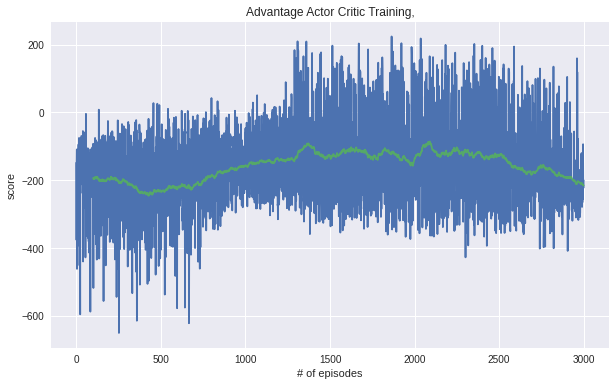

In [18]:
score = train(agent)
plot(score, 'Advantage Actor Critic')